In [1]:
import polars as pl
import os
import matplotlib.pyplot as plt

In [2]:
dir_data = '../data/ml-10M100K'

In [3]:
df_movies = (
    pl.read_csv(
        os.path.join(dir_data, 'movies.dat'),
        has_header=False,
        truncate_ragged_lines=True
    )
    .with_columns(pl.col('column_1').str.split('::'))
    .with_columns(
        pl.col('column_1').list[0].alias('movie_id'),
        pl.col('column_1').list[1].alias('title'),
        (
            pl.when(pl.col('column_1').list.len() > 2)
            .then(pl.col('column_1').list[2].str.split('|'))
            .otherwise(pl.lit([]))
            .alias('genres')
        )
    )
    .drop('column_1')
)
df_movies.head()

movie_id,title,genres
str,str,list[str]
"""1""","""Toy Story (199…","[""Adventure"", ""Animation"", … ""Fantasy""]"
"""2""","""Jumanji (1995)…","[""Adventure"", ""Children"", ""Fantasy""]"
"""3""","""Grumpier Old M…","[""Comedy"", ""Romance""]"
"""4""","""Waiting to Exh…","[""Comedy"", ""Drama"", ""Romance""]"
"""5""","""Father of the …","[""Comedy""]"


In [4]:
df_tags = (
    pl.read_csv(
        os.path.join(dir_data, 'tags.dat'),
        has_header=False,
    )
    .with_columns(pl.col('column_1').str.split('::'))
    .with_columns(
        pl.col('column_1').list[0].alias('user_id'),
        pl.col('column_1').list[1].alias('movie_id'),
        pl.col('column_1').list[2].str.to_lowercase().alias('tag'),
        pl.from_epoch(pl.col('column_1').list[3].cast(pl.Int32)).alias('timestamp')
    )
    .drop('column_1')
)
df_tags.head()

user_id,movie_id,tag,timestamp
str,str,str,datetime[μs]
"""15""","""4973""","""excellent!""",2008-07-04 15:17:10
"""20""","""1747""","""politics""",2007-08-28 01:17:47
"""20""","""1747""","""satire""",2007-08-28 01:17:47
"""20""","""2424""","""chick flick 21…",2007-08-28 01:17:15
"""20""","""2424""","""hanks""",2007-08-28 01:17:15


In [5]:
df_movies = df_movies.join(
    df_tags.group_by('movie_id').agg(pl.col('tag')),
    on='movie_id', how='left'
)
df_movies.head()

movie_id,title,genres,tag
str,str,list[str],list[str]
"""1""","""Toy Story (199…","[""Adventure"", ""Animation"", … ""Fantasy""]","[""pixar"", ""pixar"", … ""comedy""]"
"""2""","""Jumanji (1995)…","[""Adventure"", ""Children"", ""Fantasy""]","[""for children"", ""game"", … ""robin williams""]"
"""3""","""Grumpier Old M…","[""Comedy"", ""Romance""]","[""funniest movies"", ""comedinha de velhinhos engraã§ada"", … ""walter matthau""]"
"""4""","""Waiting to Exh…","[""Comedy"", ""Drama"", ""Romance""]","[""girl movie""]"
"""5""","""Father of the …","[""Comedy""]","[""steve martin"", ""pregnancy"", … ""steve martin""]"


In [6]:
df_ratings = (
    pl.read_csv(
        os.path.join(dir_data, 'ratings.dat'),
        has_header=False,
    )
    .with_columns(pl.col('column_1').str.split('::'))
    .with_columns(
        pl.col('column_1').list[0].alias('user_id'),
        pl.col('column_1').list[1].alias('movie_id'),
        pl.col('column_1').list[2].cast(pl.Float64).alias('rating'),
        pl.from_epoch(pl.col('column_1').list[3].cast(pl.Int32)).alias('timestamp')
    )
    .drop('column_1')
)
df_ratings.head()

user_id,movie_id,rating,timestamp
str,str,f64,datetime[μs]
"""1""","""122""",5.0,1996-08-02 11:24:06
"""1""","""185""",5.0,1996-08-02 10:58:45
"""1""","""231""",5.0,1996-08-02 10:56:32
"""1""","""292""",5.0,1996-08-02 10:57:01
"""1""","""316""",5.0,1996-08-02 10:56:32


## 色々な情報一覧

In [7]:
print('映画数:', df_movies.shape[0])
print('uniqueなtitleの映画数:', df_movies.get_column('title').n_unique())

映画数: 10681
uniqueなtitleの映画数: 10537


ジャンル数: 20
ジャンル一覧: ['Drama', 'Fantasy', 'Romance', 'Crime', 'Animation', 'Documentary', 'Action', 'Sci-Fi', 'Western', '(no genres listed)', 'Film-Noir', 'Children', 'IMAX', 'Horror', 'Musical', 'Thriller', 'Adventure', 'Comedy', 'Mystery', 'War']


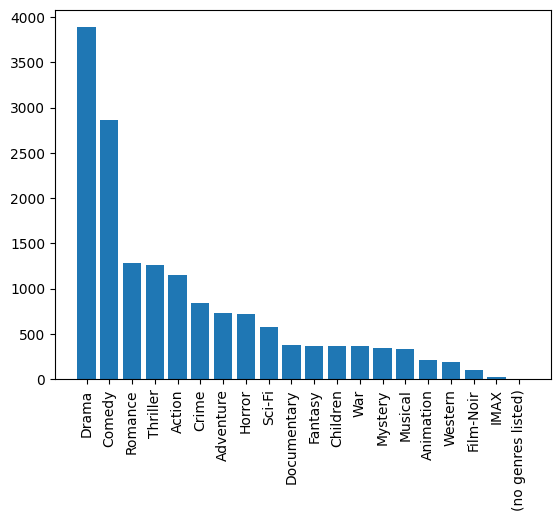

In [8]:
print('ジャンル数:', df_movies.explode('genres').get_column('genres').drop_nulls().n_unique())
print('ジャンル一覧:', df_movies.explode('genres').get_column('genres').drop_nulls().unique().to_list())
plt.bar(
    df_movies.get_column('genres').explode().value_counts(sort=True).drop_nulls().get_column('genres'),
    df_movies.get_column('genres').explode().value_counts(sort=True).drop_nulls().get_column('count')
)
plt.xticks(rotation=90)
plt.show()

In [9]:
print('タグ数:', df_tags.get_column('tag').n_unique())
print('タグレコード数:', df_tags.shape[0])
print('タグが付与されている映画数:', df_tags.get_column('movie_id').n_unique())
print('タグ付与最初日:', df_tags.get_column('timestamp').min())
print('タグ付与最終日:', df_tags.get_column('timestamp').max())

タグ数: 15240
タグレコード数: 95580
タグが付与されている映画数: 7601
タグ付与最初日: 2005-12-23 04:49:47
タグ付与最終日: 2009-01-05 04:13:10


In [10]:
print('ユーザー数:', df_ratings.get_column('user_id').n_unique())
print('レーティング付与映画数:', df_ratings.get_column('movie_id').n_unique())
print('レーティング付与最初日:', df_ratings.get_column('timestamp').min())
print('レーティング付与最終日:', df_ratings.get_column('timestamp').max())

ユーザー数: 69878
レーティング付与映画数: 10677
レーティング付与最初日: 1995-01-09 11:46:49
レーティング付与最終日: 2009-01-05 05:02:16


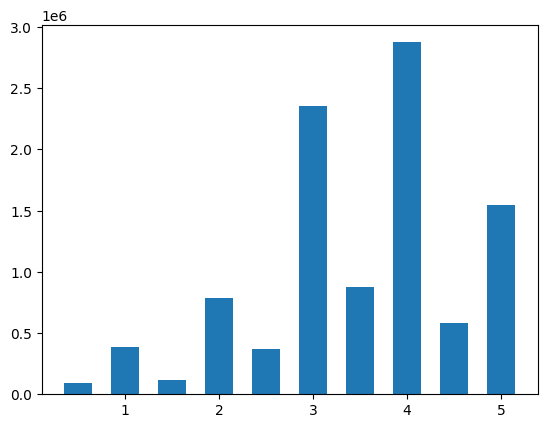

In [11]:
# ratings分布
plt.bar(
    df_ratings.get_column('rating').value_counts(sort=True).get_column('rating'),
    df_ratings.get_column('rating').value_counts(sort=True).get_column('count'),
    width=0.3
)
plt.show()